Risk - constant one as choosing A wrongfully and second as the acc
Temperature - constatnt temp
Temperature "Adaptive" - Try different temp values on the cal set and take the best (maybe use pen as val set)

Risk - As a function, try a simple model for tuning the risk

Maybe add a naive option (without google's procedure)

In [1]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = '' 

if SLURM_PATH in os.getcwd():
        CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [7]:

# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F
from tqdm.auto import tqdm
# Project imports #

import utils
utils.reload('utils')
from mind2web.dataloader import build_datasets_dict, subsample_by_annotation ,MultiChoiceDataset


# sys.path.append('./Mind2Web/src')

utils- reloaded


In [8]:
utils.reload('mind2web.dataloader')
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
model.eval();


id2split = MultiChoiceDataset.id2split
ds_dict = build_datasets_dict(id2split.values(),cache_dir=CACHE_DIR);

mind2web.dataloader- reloaded


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['decoder.embed_tokens', 'encoder.embed_tokens']
  warnings.warn(
Some parameters are on the meta device because they were offloaded to the cpu.


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [9]:
utils.reload('mind2web.dataloader')
# from mind2web.dataloader import subsample_by_annotation, MultiChoiceDataset, MultiChoiceDatasetRandom
cal_dict, pen_dict, test_dict = {}, {}, {}
seed = 42
frac = 0.2
num_candidates=5
max_context_len=512

for split, test_split in ds_dict.items():
    cal_set, test_set = subsample_by_annotation(test_split, frac=frac, seed=seed)
    cal_set, pen_set = subsample_by_annotation(cal_set, frac=0.5, seed=seed)
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )
    # pen_dict[split] = MultiChoiceDataset(
    #     pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    # )

    test_dict[split] = MultiChoiceDataset(
        test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len,cache_prompt=True, cache_tokenized=True
    )

    # cal_dict[split] = MultiChoiceDatasetRandom(
    #     cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)
    # pen_dict[split] = MultiChoiceDatasetRandom(
    #     pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)

    # test_dict[split] = MultiChoiceDatasetRandom(
    #     test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)

mind2web.dataloader- reloaded


In [ ]:
utils.reload('utils.helpers')
import math
from dataclasses import dataclass
from typing import Sequence, Literal, Tuple, Dict, Any
from scipy.stats import beta

@dataclass
class LambdaResult:
    lam: float
    p_hat: float            # empirical risky-A rate
    risk_ucb: float         # upper confidence bound on risk
    acc: float              # overall accuracy (for tie-breaking)
    n_events: int           # number of risky-A events
    n: int                  # calibration size


def hoeffding_upper_bound(p_hat: float, n: int, delta: float) -> float:
    """
    One-sided Hoeffding upper confidence bound for a Bernoulli mean.
    Guarantees:
        P(true_mean > p_hat + eps) <= delta
    where eps = sqrt(log(1/delta) / (2n)).
    """
    if n <= 0:
        raise ValueError("n must be positive.")
    eps = math.sqrt(math.log(1.0 / delta) / (2.0 * n))
    return min(1.0, p_hat + eps)


def clopper_pearson_upper(k: int, n: int, delta: float) -> float:
    """
    One-sided Clopper–Pearson upper confidence bound for a Binomial(n, p).
    """
    if n == 0:
        raise ValueError("n must be positive.")
    if k == n:  # all successes
        return 1.0
    # Upper (1 - delta) quantile of Beta(k+1, n-k)
    return float(beta.ppf(1 - delta, k + 1, n - k))

def tune_label_penalty_crc(
    scores_cal: np.ndarray,
    y_cal: np.ndarray,
    label_A: int,
    lambda_grid: Sequence[float],
    alpha: float = 0.02,
    delta: float = 0.1,
    selection: Literal["min_lambda", "max_acc"] = "min_lambda",
) -> Tuple[float, Dict[float, LambdaResult]]:
    """
    CRC-style tuning of a penalty lambda for a specific label_A.

    Parameters
    ----------
    scores_cal : array-like, shape (n_cal, K)
        Base model scores for the calibration set (logits, log-probs, etc.).
    y_cal : array-like, shape (n_cal,)
        Integer class labels in {0, ..., K-1}.
    label_A : int
        Index of the special label A to penalize.
    lambda_grid : sequence of float
        Grid of penalty values to try. (Should be sorted ascending.)
    alpha : float
        Target risk level: we want P( wrong-A ) <= alpha.
    delta : float
        Confidence level: guarantees hold with probability at least 1 - delta.
    selection : {"min_lambda", "max_acc"}
        How to pick lambda among feasible ones:
        - "min_lambda": smallest lambda with risk_ucb <= alpha.
        - "max_acc": among feasible lambdas, pick the one with largest accuracy
                     (ties broken by smaller lambda).

    Returns
    -------
    best_lambda : float
        Selected penalty lambda.
    results : dict[lambda -> LambdaResult]
        Detailed results for each lambda in the grid.

    Notes
    -----
    Risk definition:
        R(lambda) = P(ŷ_lambda(X) = A and Y != A).

    For each lambda, we:
        1. Penalize label A's score: scores[:, A] *= (1 - lambda).
        2. Predict with argmax.
        3. Compute empirical risky-A rate:
              p_hat = (# {ŷ=A, Y!=A}) / n.
        4. Build a one-sided Hoeffding UCB with per-lambda delta' = delta / |lambda_grid|.
        5. Feasible set = {lambda: risk_ucb(lambda) <= alpha}.
        6. Select lambda according to `selection`.
    """
    scores_cal = np.asarray(scores_cal, dtype=float)
    scores_cal += np.abs(scores_cal.min(axis=1).reshape(-1,1))
    y_cal = np.asarray(y_cal, dtype=int)

    if scores_cal.ndim != 2:
        raise ValueError("scores_cal must be a 2D array of shape (n_cal, K).")
    if y_cal.ndim != 1:
        raise ValueError("y_cal must be a 1D array of length n_cal.")
    n_cal, K = scores_cal.shape
    if y_cal.shape[0] != n_cal:
        raise ValueError("scores_cal and y_cal must have the same number of samples.")
    if not (0 <= label_A < K):
        raise ValueError(f"label_A must be in [0, {K-1}], got {label_A}.")
    if n_cal == 0:
        raise ValueError("Calibration set is empty.")
    if alpha <= 0 or alpha >= 1:
        raise ValueError("alpha should be in (0, 1).")
    if delta <= 0 or delta >= 1:
        raise ValueError("delta should be in (0, 1).")

    lambda_grid = list(lambda_grid)
    if len(lambda_grid) == 0:
        raise ValueError("lambda_grid must be non-empty.")

    # Bonferroni split of delta over the grid
    delta_per = delta / len(lambda_grid)

    results: Dict[float, LambdaResult] = {}

    for lam in lambda_grid:
        # Penalize label A
        penalized = scores_cal.copy()
        penalized[:, label_A] *= (1 - lam)

        # Predictions after penalty
        y_pred = penalized.argmax(axis=1)

        # Risk indicator: wrong use of A
        risky_A = (y_pred == label_A) & (y_cal != label_A)
        risky_A = (y_pred != y_cal)
        n_events = int(risky_A.sum())
        p_hat = n_events / n_cal

        # Overall accuracy (for tie-breaking)
        acc = float((y_pred == y_cal).mean())

        # One-sided Hoeffding UCB on risk
        # risk_ucb = hoeffding_upper_bound(p_hat, n_cal, delta_per)
        risk_ucb = clopper_pearson_upper(n_events, n_cal, delta_per)


        results[float(lam)] = LambdaResult(
            lam=float(lam),
            p_hat=float(p_hat),
            risk_ucb=float(risk_ucb),
            acc=acc,
            n_events=n_events,
            n=n_cal,
        )

    # Feasible set: lambdas whose UCB is <= alpha
    feasible = [res for res in results.values() if res.risk_ucb <= alpha]

    if not feasible:
        # No lambda meets the constraint; you can either:
        # - raise, or
        # - choose the lambda with smallest risk_ucb and warn.
        # Here we raise with a helpful message.
        raise RuntimeError(
            "No lambda in lambda_grid satisfies the risk constraint "
            f"(UCB <= alpha). Consider enlarging lambda_grid or increasing alpha.\n"
            "Best candidate had UCB="
            f"{min(results.values(), key=lambda r: r.risk_ucb).risk_ucb:.4f}"
        )

    if selection == "min_lambda":
        best = min(feasible, key=lambda r: r.lam)
    elif selection == "max_acc":
        # Prefer highest accuracy, then smallest lambda
        best = max(feasible, key=lambda r: (r.acc, -r.lam))
    
    else:
        raise ValueError("selection must be 'min_lambda' or 'max_acc'.")
    
    # print(f"All results: {[feas.lam for feas in feasible]}")

    return best.lam, results

cal_df = pd.read_pickle('cal_df.pkl')
cal_df = utils.helpers.add_eval_columns(cal_df)
y_cal = cal_df['target_label'].apply(lambda x: ord(x) - ord('A'))

utils.helpers- reloaded


In [359]:
# scores_cal: (n_cal, K) logits or scores
# y_cal:      (n_cal,) integer labels
# label_A:    index of the special label, e.g. 0

lambda_grid = np.linspace(0.82, 1.0, 10000)  # try penalties in [0,1] step 0.25

best_lambda, results = tune_label_penalty_crc(
    scores_cal=cal_df['choices_logits'].apply(lambda x: list(x.values())).tolist(),
    y_cal=y_cal,
    label_A=0,
    lambda_grid=lambda_grid,
    alpha=0.2,    # target wrong-A rate <= 2%
    delta=0.1,     # 90% confidence
    # selection="max_acc",
    selection="min_lambda",
    
)

print("Best lambda:", best_lambda)
print("Empirical risky-A rate at best lambda:",
      results[best_lambda].p_hat,
      "UCB:", results[best_lambda].risk_ucb,
      "accuracy:", results[best_lambda].acc)


Best lambda: 0.82
Empirical risky-A rate at best lambda: 0.10034602076124567 UCB: 0.16312138905192552 accuracy: 0.8996539792387543


In [285]:
lambda_grid[:3]

array([0.      , 0.001001, 0.002002])

In [369]:
alpha = 0.82
alpha = 0.9444
logits = cal_df['choices_logits'].apply(lambda x: list(x.values()))
logits = np.array(logits.tolist()).reshape(-1, 6) # 6 = A,.., F
logits += np.abs(logits.min(axis=1).reshape(-1,1))
logits[:,0] = logits[:,0] * (1 - alpha)

preds_raw = logits.argmax(axis=1) + 65
preds = [chr(x) for x in preds_raw]
(preds == cal_df['target_label']).mean()

np.float64(0.8875432525951558)

In [370]:
preds_df = pd.DataFrame(preds, columns=['pred'])
preds_df['correct'] = (preds_df['pred'] == cal_df['target_label'])
preds_df[preds_df['correct'] == False].value_counts()
# preds_df[preds_df['correct'] == True].value_counts()

pred  correct
F     False      27
D     False      11
B     False      10
E     False       8
C     False       7
A     False       2
Name: count, dtype: int64

In [371]:
preds_df[preds_df['correct'] == True].value_counts()
preds_df[preds_df['pred'] == 'A']
cal_df['target_label'].value_counts()
cal_df['pred_label'].value_counts()

pred_label
B    352
A    159
F     60
D      6
E      1
Name: count, dtype: int64

<Axes: >

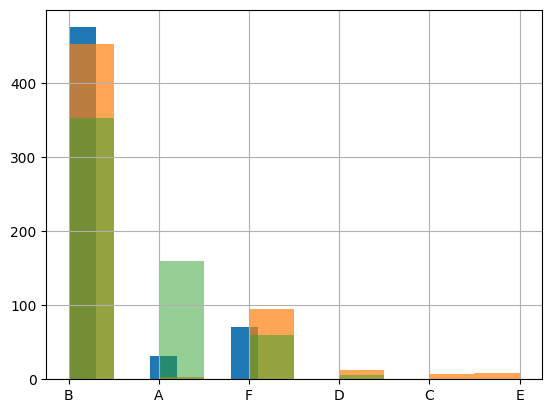

In [372]:
cal_df['target_label'].hist()
preds_df['pred'].hist(alpha=0.7)
cal_df['pred_label'].hist(alpha=0.5)

<Axes: >

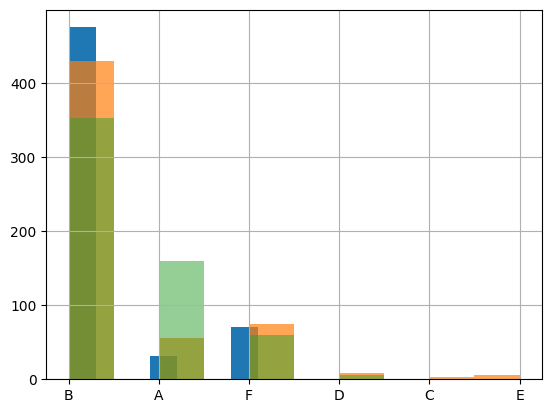

In [329]:
cal_df['target_label'].hist()
preds_df['pred'].hist(alpha=0.7)
cal_df['pred_label'].hist(alpha=0.5)

0.8803278688524591
0.7278688524590164


<Axes: >

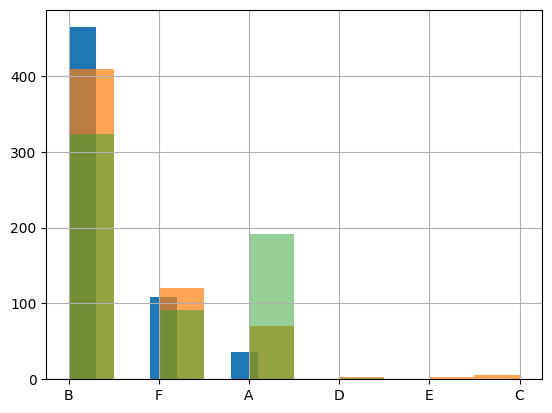

In [377]:
pen_df = pd.read_pickle('pen_df.pkl')
pen_df = utils.helpers.add_eval_columns(pen_df)
logits = pen_df['choices_logits'].apply(lambda x: list(x.values()))
logits = np.array(logits.tolist()).reshape(-1, 6) # 6 = A,.., F
logits += np.abs(logits.min(axis=1).reshape(-1,1))
logits[:,0] = logits[:,0] * (1 - 0.84)

preds_raw = logits.argmax(axis=1) + 65
preds = [chr(x) for x in preds_raw]
print((preds == pen_df['target_label']).mean())
print(pen_df['correct'].mean())


preds_df = pd.DataFrame(preds, columns=['pred'])
preds_df['correct'] = (preds_df['pred'] == pen_df['target_label'])
preds_df[preds_df['correct'] == False].value_counts()
pen_df['target_label'].hist()
preds_df['pred'].hist(alpha=0.7)
pen_df['pred_label'].hist(alpha=0.5)

In [318]:
from transformers import LogitsProcessor, LogitsProcessorList

class ShrinkageTokenProcessor(LogitsProcessor):
    def __init__(self, token_ids, shrinkage=0, device=None):
        if shrinkage < 0 or shrinkage > 1:
            raise ValueError("Shrinkage penalty must be between 0 and 1")
        
        self.shrinkage = shrinkage # Shrinkage penalty
        ids = sorted(set(token_ids)) # Makes sure that shrinkage applied only once
        self.shrink_ids = torch.tensor(ids, dtype=torch.long, device=device)

        # Indicator for making sure that shrinkage is applied only on the first token generation
        self._applied = False 

    def __call__(self, input_ids, scores):
        if self._applied:
            return scores
        
        # Softmax is shift-invariant
        min_abs_score = scores.min().abs()
        scores += min_abs_score
        
        scores[:, self.shrink_ids] *= (1 - self.shrinkage)
        self._applied = True
        return scores


In [ ]:
from torch.utils.data import DataLoader
import tqdm
utils.reload('utils.llm_utils')



utils.llm_utils- reloaded


In [2]:
import pandas as pd
import gc
import torch
from torch.utils.data import DataLoader
results = {}
for rand_idx in range(10):
    # Clear GPU memory before next iteration
    torch.cuda.empty_cache()
    gc.collect()

    loader = DataLoader(cal_dict['test_website'], batch_size=10, shuffle=False, num_workers=0, collate_fn=multichoice_collate_fn)
    results = utils.llm.batch_generate(model, tokenizer, loader, split_name='test_website')
    out = pd.DataFrame(results)
    out['rand_idx'] = rand_idx
    results = pd.concat([results,out])


NameError: name 'cal_dict' is not defined

In [304]:
for split_name, ds_split in cal_dict.items():
    print(len(ds_split), split_name)

110 test_task
381 test_domain
87 test_website


[71]
[71, 5]


In [212]:
for i in range(10):
    
    inputs = utils.llm.tensorize_item(cal_dict['test_domain'][i],'cuda')
    
    out = model.generate(
        **inputs,
        max_new_tokens=25,
        eos_token_id=model.config.eos_token_id,
        do_sample=False,
        output_scores = True,
        return_dict_in_generate=True,
    )

    output_sequences = out.sequences
    print('-----'*5, i,'-----'*5)
    print(tokenizer.decode(output_sequences[0], skip_special_tokens=True))
    scores = out['scores'][0]
    print(utils.llm.choices_probabilities(scores))
    print('-----'*5)



------------------------- 0 -------------------------
B. Action: CLICK 
{'A': 0.017824750393629074, 'B': 0.9818634986877441, 'C': 9.476371633354574e-05, 'D': 0.00010451264097355306, 'E': 3.681749149109237e-05, 'F': 7.557686330983415e-05}
-------------------------
------------------------- 1 -------------------------
A.
{'A': 0.9992904663085938, 'B': 0.00016016000881791115, 'C': 8.308587712235749e-05, 'D': 0.00013064040103927255, 'E': 0.00012319505913183093, 'F': 0.00021248958364594728}
-------------------------
------------------------- 2 -------------------------
A.
{'A': 0.9947446584701538, 'B': 0.001180701656267047, 'C': 0.00038042658707126975, 'D': 0.0014614451210945845, 'E': 0.001090462552383542, 'F': 0.001142348162829876}
-------------------------
------------------------- 3 -------------------------
A.
{'A': 0.9937885403633118, 'B': 0.002738275798037648, 'C': 0.0009917477145791054, 'D': 0.0011668922379612923, 'E': 0.000787622993811965, 'F': 0.0005270026158541441}
---------------

In [ ]:
# ban_ids = [tokenizer("A", add_special_tokens=False).input_ids[0]]
processors = LogitsProcessorList([ShrinkageTokenProcessor([MultiChoiceDataset.choice2token_id['A']], shrinkage=0.2)])
inputs=tokenizer([x],
            truncation=True,
            max_length=215,
            return_tensors="pt",
            padding=True).to("cuda:0")
out = model.generate(
    **inputs,
    logits_processor=processors,
    max_new_tokens=25,
    eos_token_id=model.config.eos_token_id,
    do_sample=False,
    output_scores = True,
    return_dict_in_generate=True,
)

output_sequences = out.sequences
print(tokenizer.decode(output_sequences[0], skip_special_tokens=True))
scores = out['scores'][0]

choice_logits = {choice:float(scores[0, idx]) for choice, idx in MultiChoiceDataset.choice2token_id.items()}
print(choice_logits)
print(utils.llm.choices_probabilities(scores))
print(utils.llm.choices_probabilities(scores, temperature=6))

A.
{'A': 53.155303955078125, 'B': 49.29962158203125, 'C': 48.54051971435547, 'D': 49.2856559753418, 'E': 0.0, 'F': 49.58189010620117}
{'A': 0.9259352684020996, 'B': 0.019592011347413063, 'C': 0.009170759469270706, 'D': 0.019320299848914146, 'E': 7.612467503476598e-24, 'F': 0.02598164975643158}
{'A': 0.32621997594833374, 'B': 0.17156435549259186, 'C': 0.15117546916007996, 'D': 0.17116545140743256, 'E': 4.6344819566002116e-05, 'F': 0.1798284351825714}


In [ ]:
E. Action: CLICK 
{'A': 53.155303955078125, 'B': 49.29962158203125, 'C': 48.54051971435547, 'D': 49.2856559753418, 'E': 54.24188995361328, 'F': 49.58189010620117}
{'A': 0.24727219343185425, 'B': 0.005232071969658136, 'C': 0.0024490628857165575, 'D': 0.005159510299563408, 'E': 0.7329486608505249, 'F': 0.006938432343304157}
{'A': 0.2345321923494339, 'B': 0.12334427982568741, 'C': 0.10868591070175171, 'D': 0.12305748462677002, 'E': 0.281094491481781, 'F': 0.12928564846515656}

tensor(53.1553, device='cuda:0')

In [ ]:
E. Action: CLICK 
tensor([[2.9538e+00, 4.4828e+01, 4.0639e+01,  ..., 2.7047e+00, 3.7731e-02,
         7.5472e-01]], device='cuda:0')
{'A': 0.24727219343185425, 'B': 0.005232071969658136, 'C': 0.0024490628857165575, 'D': 0.005159510299563408, 'E': 0.7329486608505249, 'F': 0.006938432343304157}
{'A': 0.2345321923494339, 'B': 0.12334427982568741, 'C': 0.10868591070175171, 'D': 0.12305748462677002, 'E': 0.281094491481781, 'F': 0.12928564846515656}

In [154]:
temperature_scaling = partial(torch.nn.functional.softmax, dim=-1)

In [173]:
utils.reload('utils.llm_utils')
utils.llm.choices_probabilities(scores[0], temperature=6)

utils.llm_utils- reloaded


{'A': 0.2345321923494339,
 'B': 0.12334427982568741,
 'C': 0.10868591070175171,
 'D': 0.12305748462677002,
 'E': 0.281094491481781,
 'F': 0.12928564846515656}

In [61]:
# out['scores'][0].shape
out['scores'][3].shape

torch.Size([1, 32128])

In [115]:
def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold


cal_df = pd.read_pickle("cal_results.pkl")
test_df = pd.read_pickle("test_results.pkl")
cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)

# google's nonconformity score
cal_grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - cal_grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)

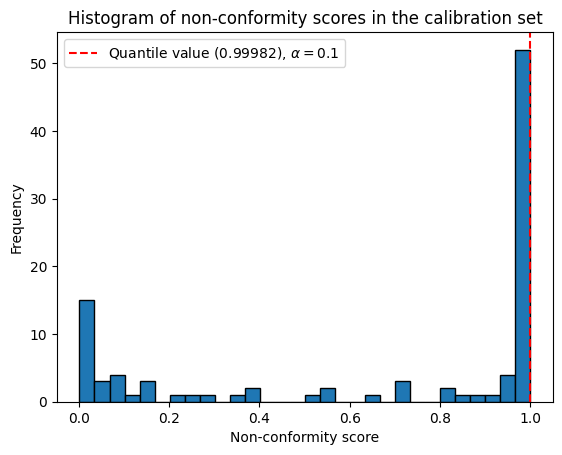

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


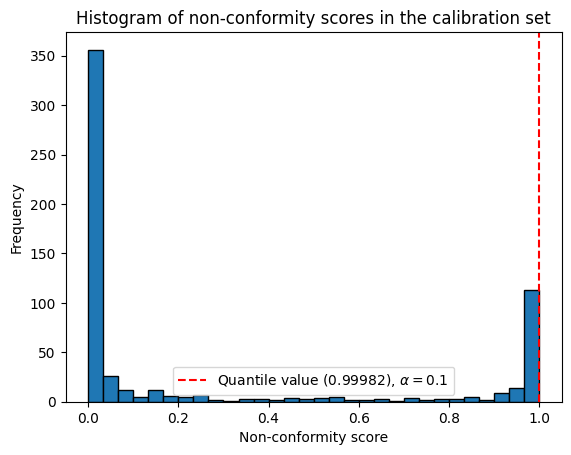

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [118]:
utils.plot.nonconformity_histogram(score_per_group, threshold)
utils.plot.nonconformity_histogram(1-cal_df['true_prob'], threshold)